# Plot Shape


In [35]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as stats
import json

LAG_MAX_MS = 250

def load_schedule(filename, rate):
    print("Reading schedule: {}".format(filename))
    data = pd.read_csv(filename, header=None, names=["time", "length"])
    data["is_outgoing"] = data["length"] > 0
    data["length"] = data["length"].abs()
    data = data.sort_values(by="time").reset_index(drop=True)

    data["time"] = pd.to_datetime(data["time"], unit="s")

    # sampling rate
    sampling = str(rate)+"ms"
    data = data.groupby("is_outgoing").resample(
                                        sampling, on="time", origin="epoch"
                                        )["length"].sum()

    return data.xs(True), data.xs(False)


def load_trace(filename, rate):
    print("Reading trace: {}".format(filename))
    data = pd.read_csv(filename)
    assert data.loc[0, "packet_number"] == 0
    data["timestamp"] = (data["timestamp"] - data.loc[0, "timestamp"]) * 1e3
    data = data.rename(columns={"timestamp": "time",
                                "packet_length": "length"})
    data = data[["time", "length", "is_outgoing"]]
    data["time"] = pd.to_datetime(data["time"], unit="ms")

    sampling = str(rate)+"ms"
    data = data.groupby("is_outgoing").resample(
                                        sampling, on="time", origin="epoch"
                                        ).sum().drop(columns="is_outgoing")

    return data.xs(True)["length"], data.xs(False)["length"]


Reading trace: ../results/collect/tamaraw_defended/config2/016_0/tamaraw_traffic.csv
Reading schedule: ../results/collect/tamaraw_defended/config2/016_0/shape_schedule.csv


Text(0.5, 0.98, '')

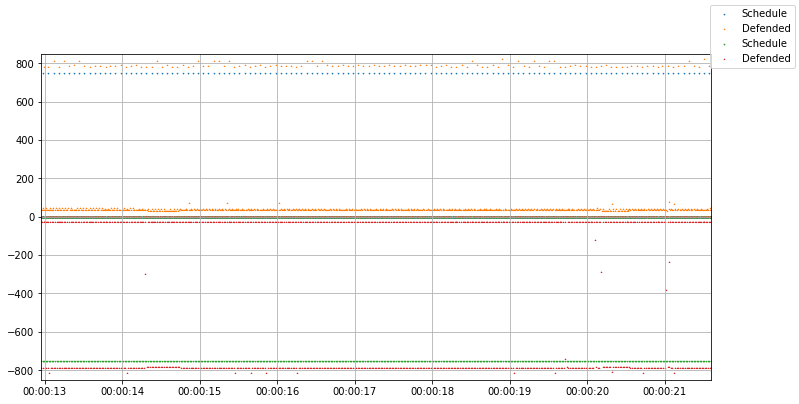

In [58]:

config = "config2"
s_id="016"
r_id="0"

TRACE_F = f"../results/collect/tamaraw_defended/{config}/{s_id}_{r_id}/tamaraw_traffic.csv"
SCHEDULE_F = f"../results/collect/tamaraw_defended/{config}/{s_id}_{r_id}/shape_schedule.csv"

sample_rate = 5
r_window_size = int(6250/sample_rate)

(outgoing, incoming) = load_trace(TRACE_F, float(sample_rate))
(schedule_out, schedule_in) = load_schedule(SCHEDULE_F, float(sample_rate))

f, ax = plt.subplots(1,1, figsize=(12,6))
ax.scatter(x=schedule_out.index, y=schedule_out, label="Schedule", s=1.5, marker='2')
ax.scatter(x=outgoing.index, y=outgoing, label="Defended", s=1.0, marker='1')
ax.scatter(x=schedule_in.index, y=-schedule_in, label="Schedule", s=1.5, marker='2')
ax.scatter(x=incoming.index, y=-incoming, label="Defended", s=1.0, marker='1')
ax.set_ylim(bottom=-850, top=850)
ax.set_xlim(left=0.00015, right=0.00025)
ax.grid()
f.legend()
f.suptitle(f"")


